In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_func, gammaln, loggamma, gdtrix
from scipy.special import logsumexp as logsumexp

import bilby
import ptemcee

# Helper Stuff

In [2]:
class SimpleGaussianLikelihood(bilby.Likelihood):
    def __init__(self, data):
        """
        A very simple Gaussian likelihood.

        Parameters
        ----------
        data: array_like
            The data to analyse
        """
        super().__init__(parameters={'mu': None, 'sigma': None})
        self.data = data
        self.N = len(data)

    def log_likelihood(self):
        mu = self.parameters['mu']
        sigma = self.parameters['sigma']
        res = self.data - mu
        return ( -0.5 * (np.sum((res / sigma)**2) +
                       self.N * np.log(2 * np.pi * sigma**2)) )

class GeneralizedNormalLikelihood(bilby.Likelihood):
    def __init__(self, data):
        """
        A generalized normal distribution: 
        https://en.wikipedia.org/wiki/Generalized_normal_distribution

        Parameters
        ----------
        data: array_like
            The data to analyse
        """
        super().__init__(parameters={'mu': None, 'alpha': None, 'beta': None})
        self.data = data
        self.N = len(data)

    def log_likelihood(self):
        mu = self.parameters['mu']
        alpha = self.parameters['alpha']
        beta = self.parameters['beta']
        
        res = self.data - mu
        
        return ( -1 * np.sum( ( np.abs(res) / alpha )**beta ) 
                + self.N * ( np.log(beta / (2 * alpha)) - loggamma(1/beta) ) )

In [3]:
def generalized_gaussian_dist(mu, alpha, beta, N):
    """
    Draws N samples from a generalized gaussian distribution specified by
    mean mu, scale alpha, and shape beta.
    See https://en.wikipedia.org/wiki/Generalized_normal_distribution.

    In this implementation, we draw N samples from a uniform distribution on
    [0,1], and then use the inverse cumulative distribution function (CDF) of
    the generalized gaussian to convert this into a generalized gaussian
    distribution of samples.

    Parameters
    ==========
    mu : float
        Mean of the disitribution, like the mean of a standard Gaussian distribution.
    alpha : float
        Scale of the distribution; in the case of a standard Gaussian distribution
        (beta = 2), alpha is related to the standard deviation sigma as 
        sigma = alpha / sqrt(2).
    beta : float
        Shape of the distribution; for example, when beta = 1 we have the
        Laplace distribution, and when beta = 2, we have a standard Gaussian
        distribution.
    N : int
        Number of samples to generate from the generalized gaussian distribution
        specified by mu, alpha, and beta.

    Returns
    =======

    """

    # Uses the inverse CDF to generate a generalized gaussian distribution
    # Note: scipy and wikipedia switch the order of the shape, scale parameters!
    # https://en.wikipedia.org/wiki/Generalized_normal_distribution
    # https://en.wikipedia.org/wiki/Gamma_distribution
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gdtrix.html#scipy.special.gdtrix
    rand_draws = np.random.uniform(0,1,size=N)
    return np.sign( rand_draws - 0.5 ) * gdtrix( 
        1/(alpha**beta), 
        1/beta, 
        2 * np.abs(rand_draws - 0.5) )**(1/beta) + mu

def alpha_to_sigma(alpha):
    """
    Convert from the generalized Gaussian scale parameter, alpha, to that of the
    standard Gaussian, the standard deviation sigma.

    Parameters
    ==========
    alpha : float
        Generalized Gaussian scale parameter.
    """
    return np.sqrt( 1/2 * (alpha**2) )

def sigma_to_alpha(sigma):
    return sigma * np.sqrt(2)

# Well-specified Model

In [4]:
N = 1000
mu_true = 3
alpha_true = 4 * np.sqrt(2)
beta_true = 2

data = generalized_gaussian_dist(mu_true, alpha_true, beta_true, N)

## First Step - Dynesty

In [5]:
label = "wellspecified_dynesty-step"
outdir = "./wellspecified/wellspecified_dynesty-step" 

gaussian_likelihood = SimpleGaussianLikelihood(data)
priors = dict(
    mu=bilby.core.prior.Uniform(0, 5, 'mu'),
    sigma=bilby.core.prior.Uniform(0, 10, 'sigma'),
)

N_live = 500

# And run sampler
result_hybrid_nest = bilby.run_sampler(
    likelihood=gaussian_likelihood, priors=priors, sampler='dynesty', npoints=N_live,
    walks=10, outdir=outdir, label=label)

12:09 bilby INFO    : Running for label 'wellspecified_dynesty-step', output will be saved to './wellspecified/wellspecified_dynesty-step'
12:09 bilby INFO    : Search parameters:
12:09 bilby INFO    :   mu = Uniform(minimum=0, maximum=5, name='mu', latex_label='mu', unit=None, boundary=None)
12:09 bilby INFO    :   sigma = Uniform(minimum=0, maximum=10, name='sigma', latex_label='sigma', unit=None, boundary=None)
12:09 bilby INFO    : Single likelihood evaluation took 6.893e-05 s


12:09 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7ff1817071c0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
12:09 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:09 bilby INFO    : Using dynesty version 1.0.1
12:09 bilby INFO    : Using the bilby-implemented rwalk samp

12:10 bilby INFO    : Sampling time: 0:00:17.114549
12:10 bilby INFO    : Summary of results:
nsamples: 4884
ln_noise_evidence:    nan
ln_evidence: -2819.499 +/-  0.147
ln_bayes_factor:    nan +/-  0.147



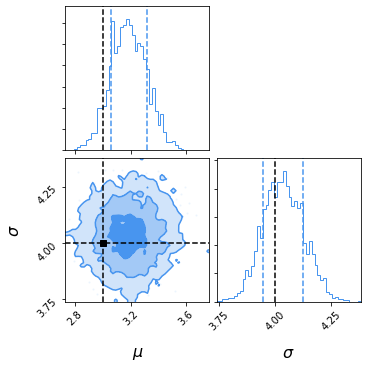

In [6]:
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = result_hybrid_nest.plot_corner(
        parameters=dict(
            mu=mu_true,
            sigma=alpha_to_sigma(alpha_true)
        ),
        titles=False,
        labels=[r"$\mu$", r"$\sigma$"],
        color="#4895ef",
        truth_color="black",
        dpi=80
    )

fig

## Second Step - ptemcee

### Setup Tempered Initial Points

In [7]:
label_pt = "wellspecified_ptemcee-step"
outdir_pt = "./wellspecified/wellspecified_ptemcee-step"

ndims    = 3   # 3 dimensions i.e. parameters, {mu, alpha, beta}
nwalkers = 200 # number of walkers in our ensemble
ntemps   = 7   # number of temperatures in our ensemble

# generate the temperatures in our ensemble
temperatures = ptemcee.default_beta_ladder(
    ndim=ndims,            
    ntemps=ntemps,
    Tmax=None
)

In [8]:
# temper the initial samples in {mu, sigma} from dynesty,
# to prepare them as initial points for ptemcee
nested_samples = result_hybrid_nest.nested_samples
log_likelihood = nested_samples["log_likelihood"].values
nnest = len(nested_samples)

# TODO: this code needs some explanation, plus some math in a cell above it!
tempered_posterior_weights = np.zeros((ntemps, nnest))
for j, beta_T in enumerate(temperatures):
    log_likelihood_beta = log_likelihood * beta_T

    i = np.arange(0, nnest, 1)
    logw = -1 * i / N_live + np.log( np.exp(1/N_live) - 1 )
        
    a = log_likelihood_beta + logw
    logZ = logsumexp( a )
    logp = log_likelihood_beta + logw - logZ
    p = np.exp(logp)

    tempered_posterior_weights[j,:] = p

# TODO: this code also needs some explanation
pos0 = np.zeros((ntemps, nwalkers, ndims))
for j, beta_T in enumerate(temperatures):
    rand_sample_idxs = np.random.choice(
        nnest, size=nwalkers, 
        p=tempered_posterior_weights[j] / np.sum(tempered_posterior_weights[j])
    )

    pos0[j,:,0] = nested_samples["mu"][rand_sample_idxs]
    pos0[j,:,1] = sigma_to_alpha( nested_samples["sigma"][rand_sample_idxs] )
    pos0[j,:,2] = np.random.normal(loc=2, scale=0.1, size=nwalkers)

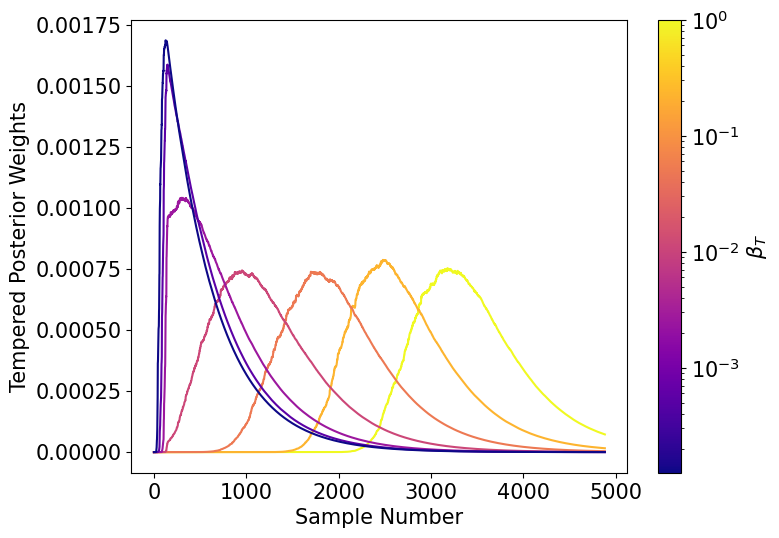

In [9]:
# plot the tempered posterior weights
# generates Figure XX from the report
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
ax.set_xlabel("Sample Number", fontsize=15)
ax.set_ylabel(r"Tempered Posterior Weights", fontsize=15)
ax.tick_params(labelsize=15)

log10_temperatures = np.log10(temperatures)
colors = plt.cm.plasma(
    mpl.colors.Normalize(
        vmin = log10_temperatures.min(),
        vmax = log10_temperatures.max()
    )(log10_temperatures)
)

for j, beta_T in enumerate(temperatures):
    ax.plot( tempered_posterior_weights[j,:], color=colors[j] )

sm = plt.cm.ScalarMappable(
    cmap=mpl.cm.plasma, 
    norm=mpl.colors.LogNorm(vmin=min(temperatures), vmax=max(temperatures)),
)
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel(r"$\beta_T$", fontsize=15)
cbar.ax.tick_params(labelsize=15)

12:10 bilby INFO    : Running for label 'wellspecified_ptemcee-step', output will be saved to './wellspecified/wellspecified_ptemcee-step'
12:10 bilby INFO    : Search parameters:
12:10 bilby INFO    :   mu = Uniform(minimum=0, maximum=5, name=None, latex_label='$\\mu$', unit=None, boundary=None)
12:10 bilby INFO    :   alpha = Uniform(minimum=0, maximum=14.142135623730951, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
12:10 bilby INFO    :   beta = Uniform(minimum=0, maximum=10, name=None, latex_label='$\\beta$', unit=None, boundary=None)
12:10 bilby INFO    : Single likelihood evaluation took 2.477e-04 s
12:10 bilby WARNING : Supplied argument 'npool' not an argument of 'Ptemcee', removing.
12:10 bilby INFO    : Using sampler Ptemcee with kwargs {'ntemps': 7, 'nwalkers': 200, 'Tmax': None, 'betas': array([1.00000000e+00, 2.23462688e-01, 4.99355731e-02, 1.11587374e-02,
       2.49356146e-03, 5.57217948e-04, 1.24517421e-04]), 'a': 2.0, 'adaptation_lag': 10000, 'adaptati

213|0:04:53|nc:1.5e+06|a0:0.60-0.68|swp:0.24-0.87|n:22600<5000|t=2(+0.01,+0.07)|q:1.00|0.20ms/ev


12:10 bilby INFO    : Finished sampling
12:10 bilby INFO    : Writing checkpoint and diagnostics
12:10 bilby INFO    : Finished writing checkpoint
12:10 bilby INFO    : Sampling time: 0:04:53.156366
12:10 bilby INFO    : Summary of results:
nsamples: 22600
ln_noise_evidence:    nan
ln_evidence: -2825.024 +/- 11.678
ln_bayes_factor:    nan +/- 11.678



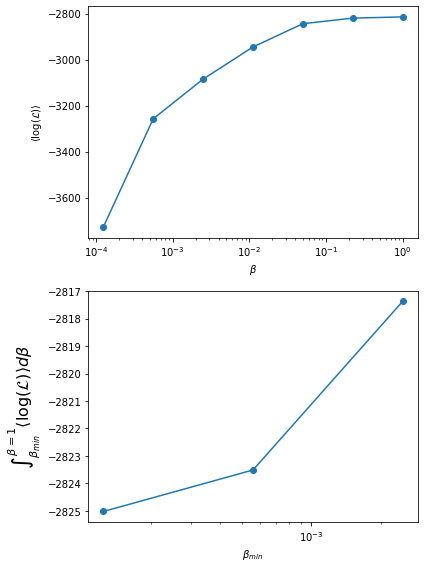

In [10]:
generalized_gaussian_likelihood = GeneralizedNormalLikelihood(data)

priors_pt = dict(
    mu=bilby.core.prior.Uniform(minimum=0,maximum=5, latex_label=r"$\mu$"),
    alpha=bilby.core.prior.Uniform(minimum=0,maximum=10 * np.sqrt(2), latex_label=r"$\alpha$"),
    beta=bilby.core.prior.Uniform(minimum=0,maximum=10, latex_label=r"$\beta$")
)

result_hybrid_pt = bilby.run_sampler(
    likelihood=generalized_gaussian_likelihood, 
    pos0=pos0, 
    priors=priors_pt, 
    outdir=outdir_pt,
    ntemps=ntemps,
    betas=temperatures,
    nwalkers=nwalkers,
    label=label_pt, 
    sampler='ptemcee',
)

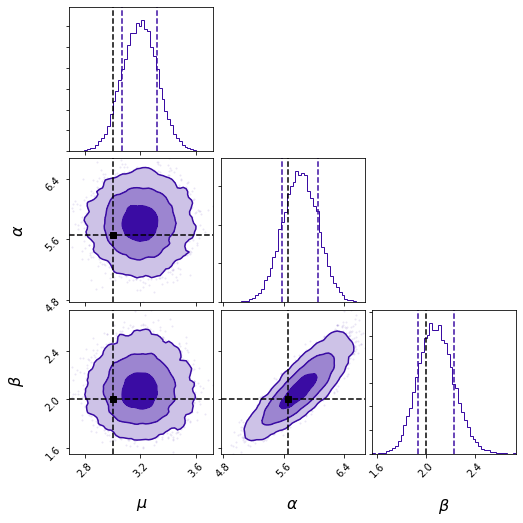

In [11]:
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = result_hybrid_pt.plot_corner(
        parameters=dict(
            mu=mu_true,
            alpha=alpha_true,
            beta=beta_true
        ),
        titles=False,
        color="#3a0ca3",
        truth_color="black",
        dpi=80
    )

fig

## With Dynesty Alone

In [12]:
label_nest_only = "wellspecified_dynesty-only"
outdir_nest_only = "./wellspecified/wellspecified_dynesty-only" 

generalized_gaussian_likelihood = GeneralizedNormalLikelihood(data)
priors_nest_only = dict(
    mu=bilby.core.prior.Uniform(minimum=0,maximum=5, latex_label=r"$\mu$"),
    alpha=bilby.core.prior.Uniform(minimum=0,maximum=10 * np.sqrt(2), latex_label=r"$\alpha$"),
    beta=bilby.core.prior.Uniform(minimum=0,maximum=10, latex_label=r"$\beta$")
)

N_live = 500

# And run sampler
result_hybrid_nest_only = bilby.run_sampler(
    likelihood=generalized_gaussian_likelihood, priors=priors_nest_only, sampler='dynesty', npoints=N_live,
    walks=10, outdir=outdir_nest_only, label=label_nest_only)

12:10 bilby INFO    : Running for label 'wellspecified_dynesty-only', output will be saved to './wellspecified/wellspecified_dynesty-only'
12:10 bilby INFO    : Search parameters:
12:10 bilby INFO    :   mu = Uniform(minimum=0, maximum=5, name=None, latex_label='$\\mu$', unit=None, boundary=None)
12:10 bilby INFO    :   alpha = Uniform(minimum=0, maximum=14.142135623730951, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
12:10 bilby INFO    :   beta = Uniform(minimum=0, maximum=10, name=None, latex_label='$\\beta$', unit=None, boundary=None)
12:10 bilby INFO    : Single likelihood evaluation took 2.492e-04 s


12:10 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7ff1635aa190>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
12:10 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:10 bilby INFO    : Using dynesty version 1.0.1
12:10 bilby INFO    : Using the bilby-implemented rwalk samp

12:10 bilby INFO    : Sampling time: 0:00:55.340390
12:10 bilby INFO    : Summary of results:
nsamples: 6613
ln_noise_evidence:    nan
ln_evidence: -2822.847 +/-  4.433
ln_bayes_factor:    nan +/-  4.433



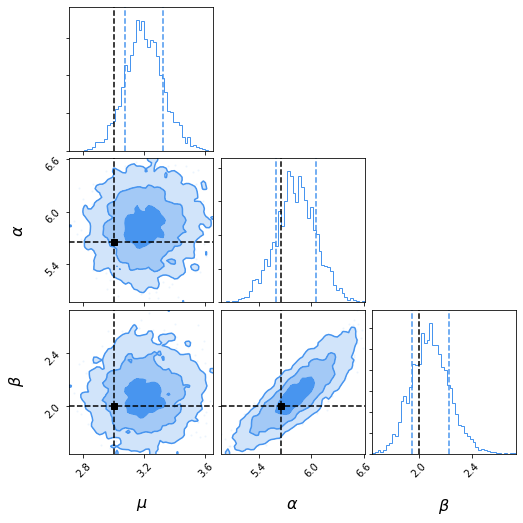

In [13]:
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = result_hybrid_nest_only.plot_corner(
        parameters=dict(
            mu=mu_true,
            alpha=alpha_true,
            beta=beta_true
        ),
        titles=False,
        labels=[r"$\mu$", r"$\alpha$", r"$\beta$"],
        color="#4895ef",
        truth_color="black",
        dpi=80
    )

fig

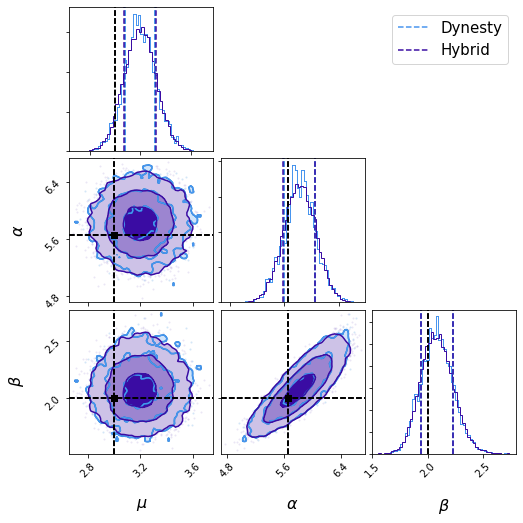

In [14]:
## Combined Corner plot of dynesty-only, hybrid results
with plt.rc_context({'lines.linestyle' : '--', 'legend.fontsize' : 15}):
    fig = bilby.core.result.plot_multiple(
        [result_hybrid_nest_only, result_hybrid_pt],
        labels=["Dynesty", "Hybrid"],
        colours=["#4895ef", "#3a0ca3"],
        titles=False,
        truth_color="black",
        parameters=dict(
            mu=mu_true,
            alpha=alpha_true,
            beta=beta_true
        ),
    )

In [53]:
fig.get_axes()[-1].get_legend().get_texts().set_fontsize(20)

AttributeError: 'silent_list' object has no attribute 'set_fontsize'

In [ ]:



with plt.rc_context({'lines.linestyle' : '--'}):
    fig = result_hybrid_pt.plot_corner(
        parameters=dict(
            mu=mu_true,
            alpha=alpha_true,
            beta=beta_true
        ),
        titles=False,
        color="#3a0ca3",
        truth_color="black",
        dpi=80
    )

fig


## Plot Sampler Evolution

In [12]:
def plot_evolution(nest_result, hybrid_result, hybrid_resume, xparam, yparam, xlabel, ylabel, xtrue, ytrue, title, pos0 = None, iterations = None, xnest_val=0):
    xidx = hybrid_result.search_parameter_keys.index(xparam)
    y_hybrid_idx = hybrid_result.search_parameter_keys.index(yparam)
    y_nest_idx = nest_result.search_parameter_keys.index(yparam)
    
    nnest, _ = nest_result.samples.shape
    
    nrows, ncols = (3,4)
    fig, axes = plt.subplots(figsize=(12,8), dpi=300, nrows=nrows, ncols=ncols, sharex="col", sharey="row")
    fig.supxlabel(xlabel, fontsize=15, x=0.6175, y=0.05)
    fig.supylabel(ylabel, fontsize=15, x=0.05,   y=0.3725)
    #fig.suptitle(title, fontsize=15)

    if iterations is None:
        iterations = np.array([0,2,16,128,256,499])
    
    interior_axes = [
           axes[i,j] for i in range(1,nrows) for j in range(1,ncols)
    ]
    
    top_hists = [ axes[0,j] for j in range(1,ncols) ]
    left_hists = [ axes[i,0] for i in range(1,nrows) ] 
    
    for ax in interior_axes:
        ax.get_shared_x_axes().join(ax, *interior_axes)
        ax.get_shared_y_axes().join(ax, *interior_axes)
        
        ax.get_shared_x_axes().join(ax, *top_hists)
        ax.get_shared_y_axes().join(ax, *left_hists)
    
    axes[0,0].axis('off')
    
    nest_color = "#4895ef" #mpl.cm.get_cmap('Blues')(0.6) #"#e0bbc9"
    hybrid_colors = np.array(["#f72585"] + [ "#B450F7", "#9B15F4", "#7D19F0", "#6210E5", "#3a0ca3" ], dtype="object")
        
    hybrid_chain = hybrid_resume["chain_array"]
    
    ### top hists ###  
    for k,ax in enumerate(top_hists):
        for color,it in zip(hybrid_colors[k::nrows],iterations[k::nrows]):
            if it == 0 and pos0 is not None:
                xdata = pos0[0,:,xidx]
            else:
                xdata = hybrid_chain[:,it,xidx]
            ax.hist(xdata, density=True, color=color, histtype="step", zorder=0)
            
        ax.axvline(x=xtrue, linestyle="--", color="black", zorder=-1)
            
    ### left hists ###
    for k,ax in enumerate(left_hists):
        if k == 0:
            ax.hist(
                nest_result.samples[:,y_nest_idx], 
                density=True, color=nest_color, histtype="step", orientation="horizontal",
                zorder=1
            )

        
        for color,it in zip(hybrid_colors[k*(ncols-1):(k+1)*(ncols-1)],iterations[k*(ncols-1):(k+1)*(ncols-1)]):
            if it == 0 and pos0 is not None:
                ydata = pos0[0,:,y_hybrid_idx]
            else:
                ydata = hybrid_chain[:,it,y_hybrid_idx]
            ax.hist(ydata, density=True, color=color, histtype="step", orientation="horizontal", zorder=0)
            
        ax.axhline(y=ytrue, linestyle="--", color="black", zorder=-1)
        
        if k == len(left_hists)-1:
            ax.set_xlim( ax.get_xlim()[::-1] )

    
    ### interior plots ###
    for k,(color,it,ax) in enumerate(zip(hybrid_colors,iterations,interior_axes)):
        xdata = hybrid_chain[:,it,xidx]
        ydata = hybrid_chain[:,it,y_hybrid_idx]
        
        ax.axvline(x=xtrue, linestyle="--", color="black", zorder=-1)
        ax.axhline(y=ytrue, linestyle="--", color="black", zorder=-1)
        
        if k == 0:
            ax.scatter(
                np.tile(xnest_val, nnest), nest_result.samples[:,y_nest_idx],
                s=2,
                c=nest_color,
                zorder=1
            )

            if pos0 is None:
                ax.scatter(
                    xdata, ydata,
                    s=2,
                    c=color,
                    zorder=0
                )
            else:
                print(xidx, y_hybrid_idx)
                ax.scatter( pos0[0,:,xidx], pos0[0,:,y_hybrid_idx], s=2, c=color, zorder=0 )

            ax.set_title("Initialization")
        else:
            ax.scatter(
                xdata, ydata,
                s=2, c=color,
                zorder=1,
            )

            ax.set_title("Step %d" % it )
            
    axes[-1,0].set_xticklabels([])
    return fig, axes

2 0


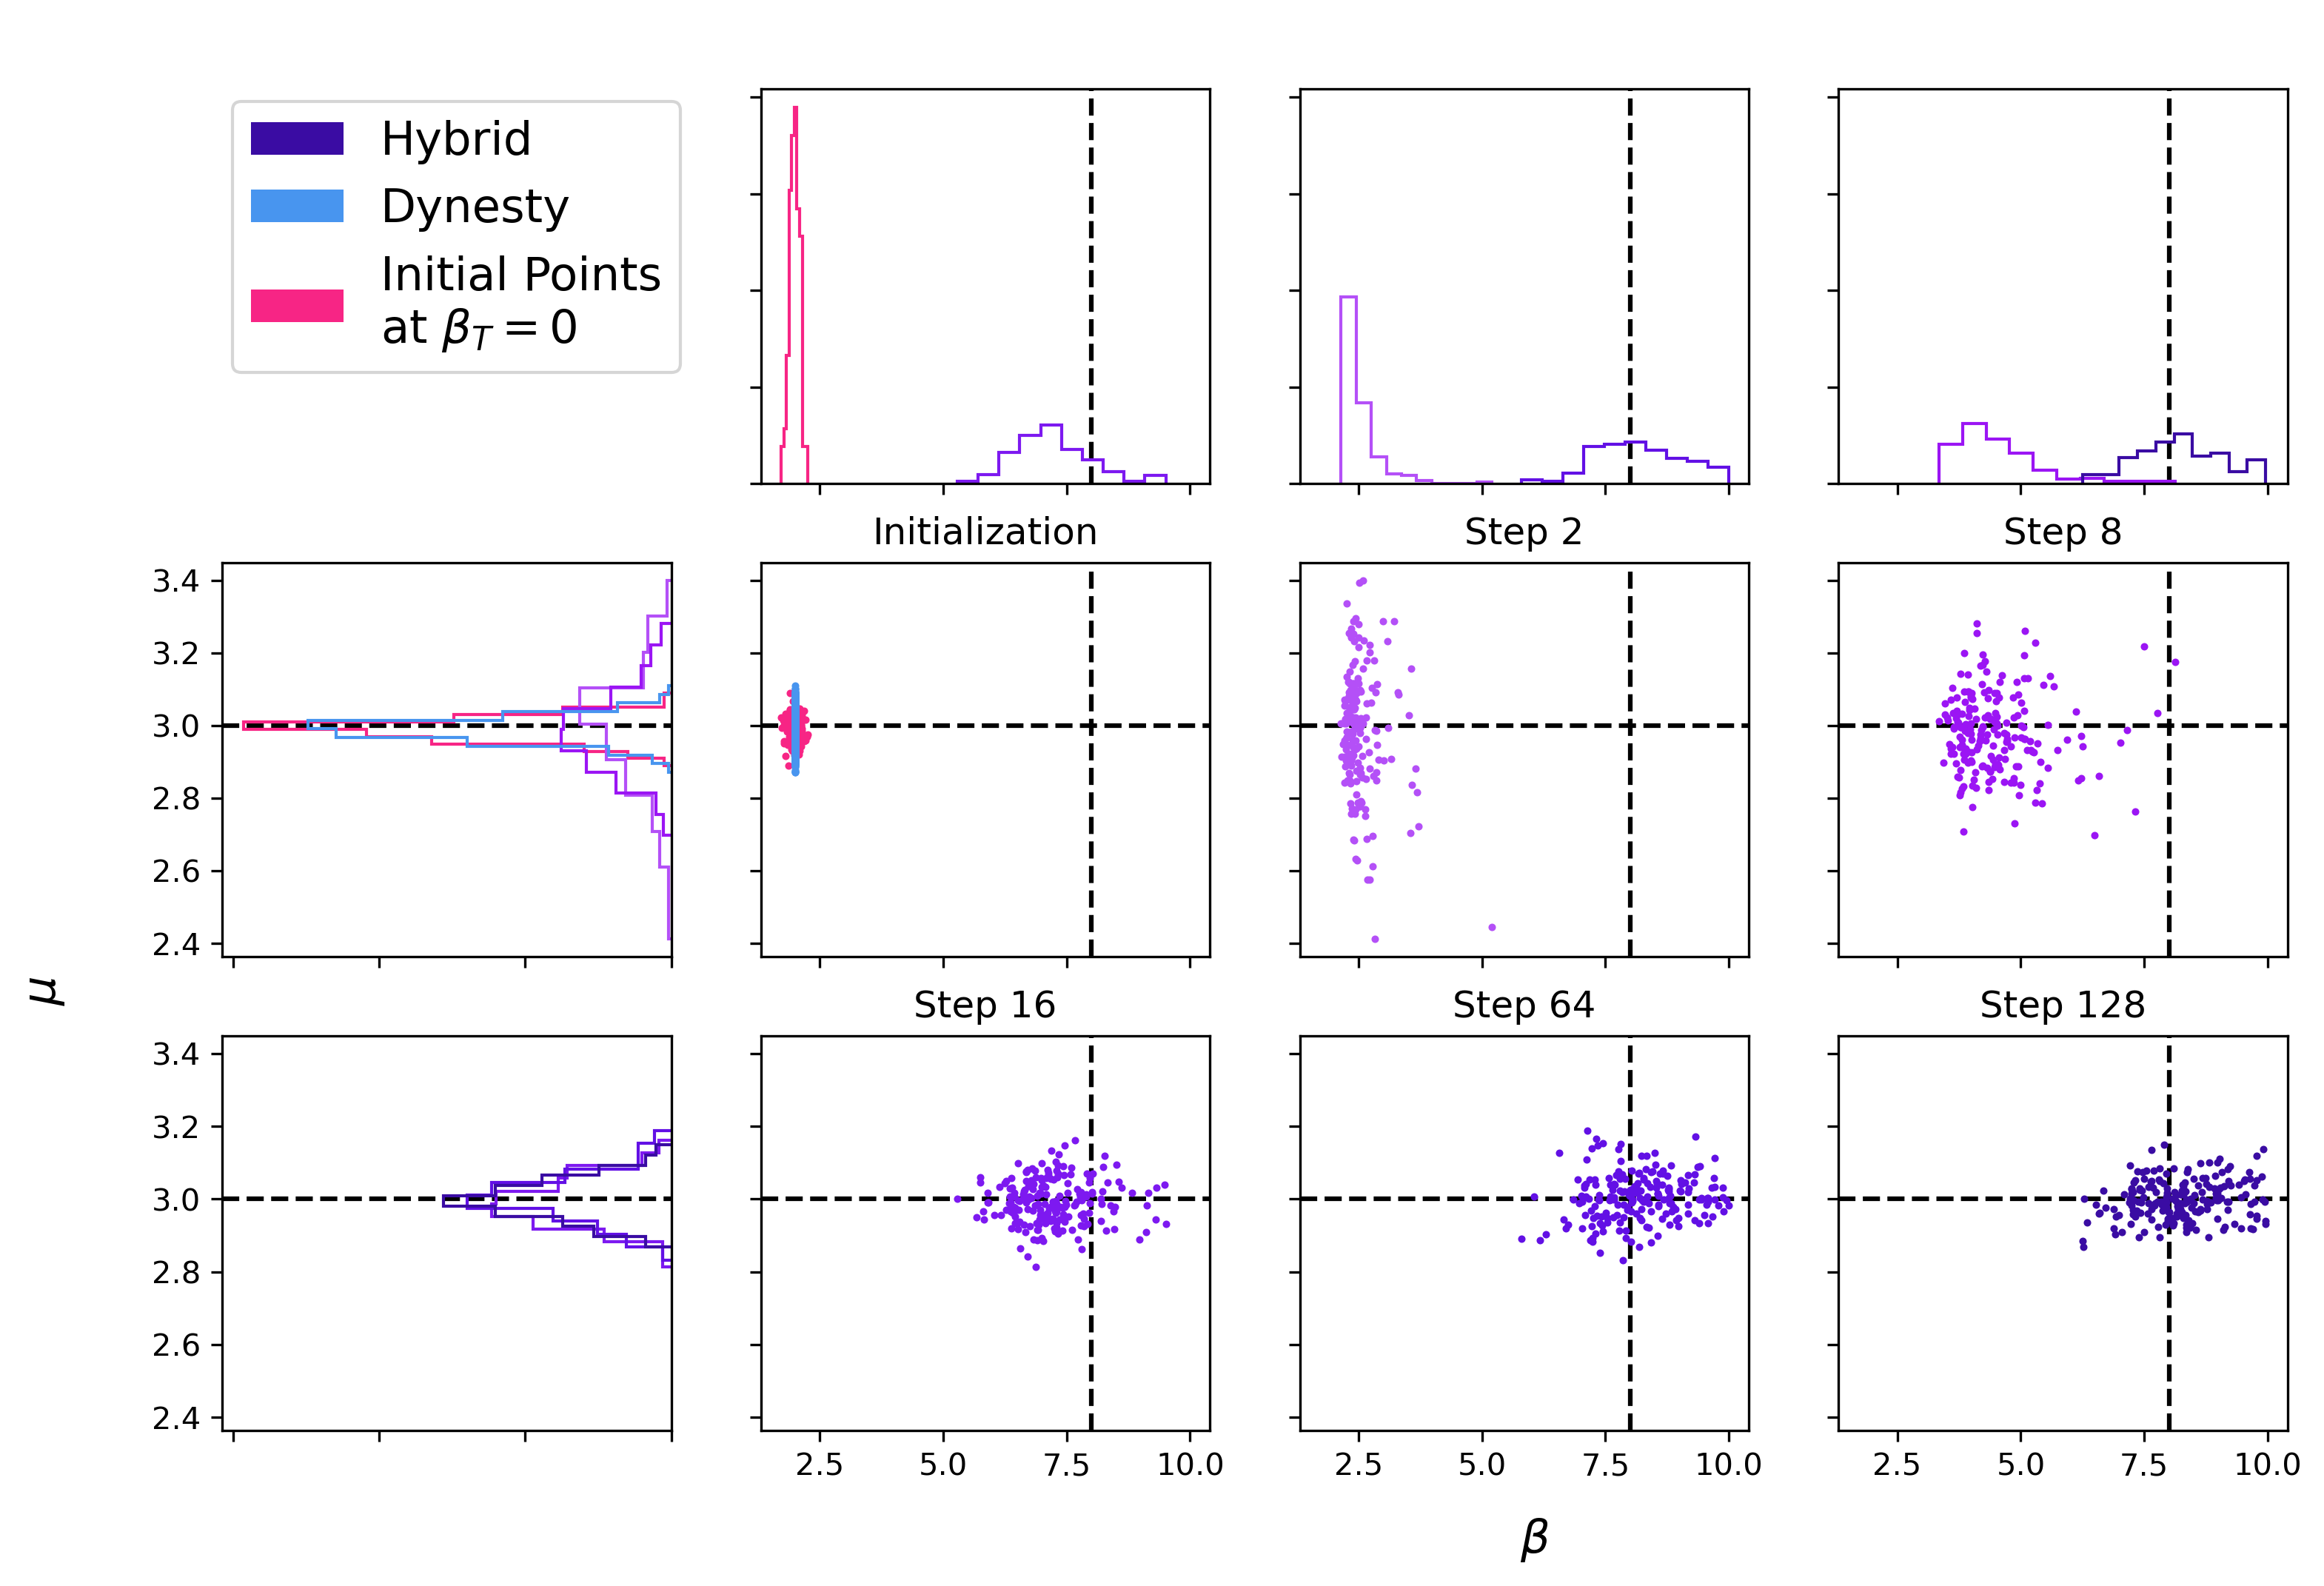

In [25]:
import dill

with open("./misspecified/misspecified_ptemcee-step/misspecified_ptemcee-step_checkpoint_resume.pickle", "rb") as f:
    pt_resume = dill.load(f)

fig, axes = plot_evolution(
    result_hybrid_nest, result_hybrid_pt, pt_resume, "beta", "mu", r"$\beta$", r"$\mu$", beta_true, mu_true, "fart", 
    iterations = np.array([0,2,8,16,64,128]), pos0=pos0, xnest_val=2
)

fig.legend(
    [ mpl.patches.Patch(facecolor="#3a0ca3"), mpl.patches.Patch(facecolor="#4895ef"), mpl.patches.Patch(facecolor="#f72585") ],
    [ "Hybrid", "Dynesty", "Initial Points\nat $\\beta_T = 0$" ],
    fontsize=15,
    loc=(0.1,0.765)
)

2 1


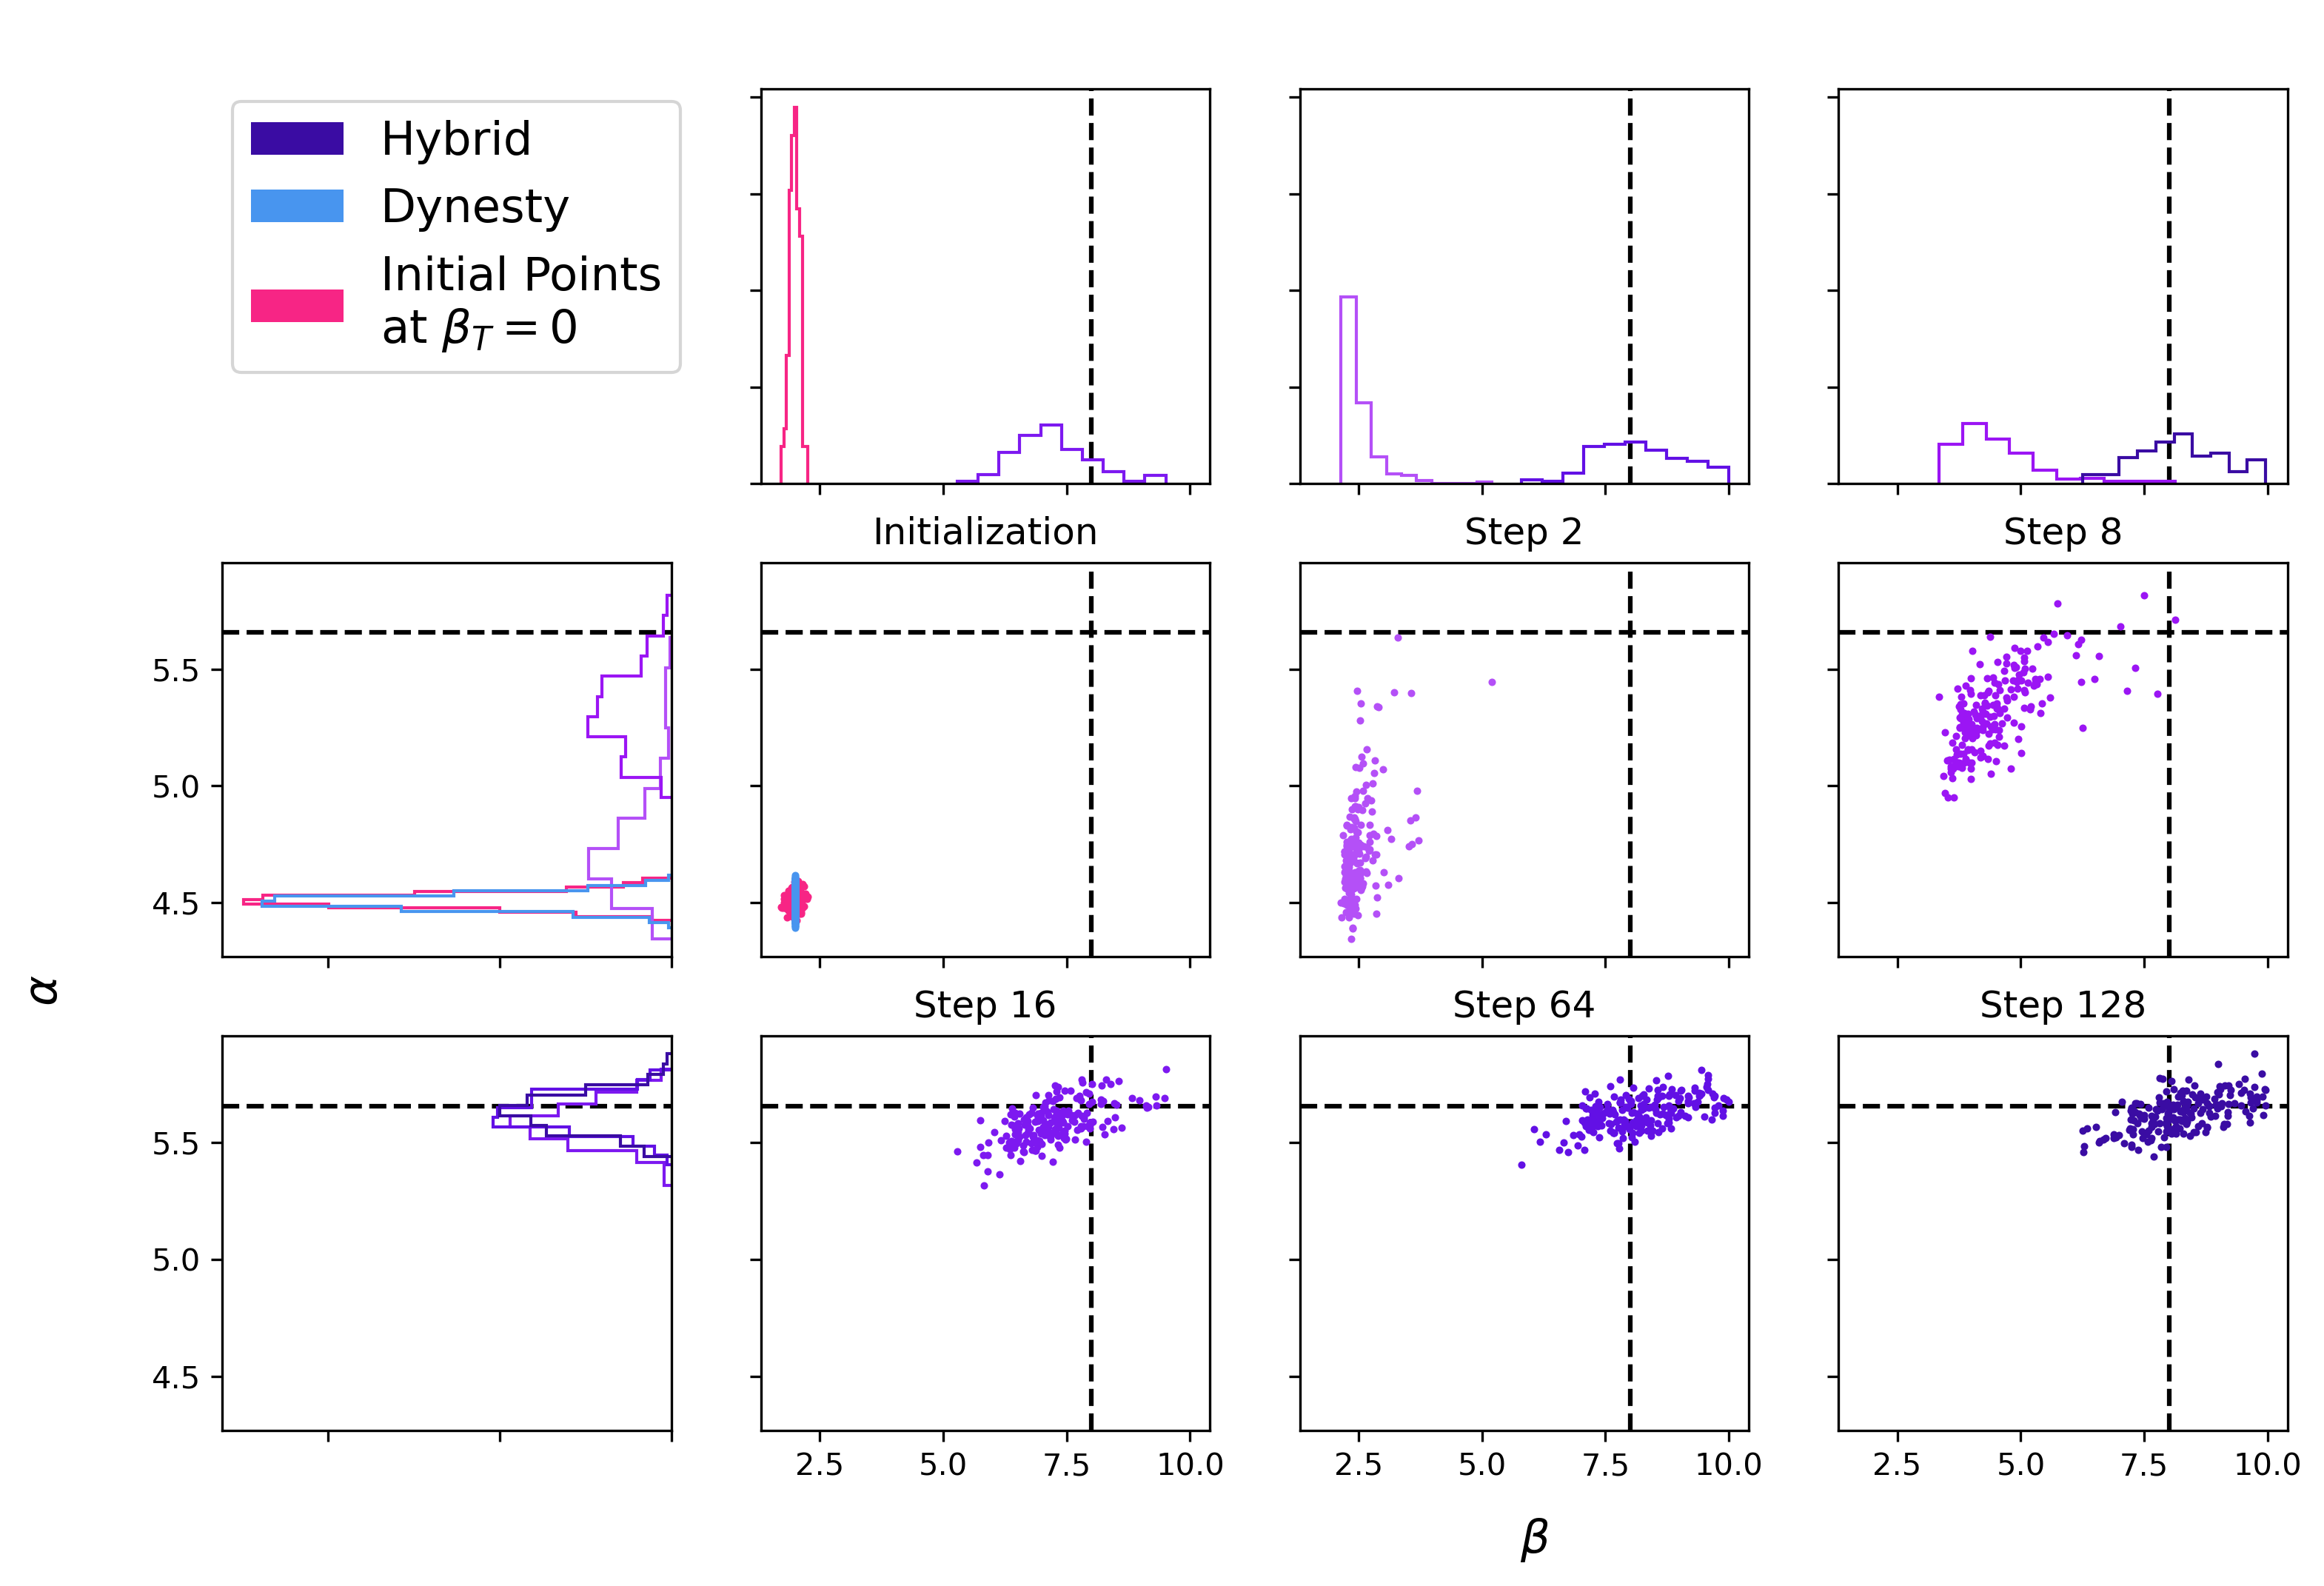

In [24]:
result_hybrid_nest2 = bilby.core.result.read_in_result("./misspecified/misspecified_dynesty-step/misspecified_dynesty-step_result.json")
result_hybrid_nest2.search_parameter_keys.append("alpha")
result_hybrid_nest2.samples = np.stack((
    result_hybrid_nest2.samples[:,0],
    result_hybrid_nest2.samples[:,1],
    sigma_to_alpha( result_hybrid_nest2.samples[:,1] )
)).T

fig, axes = plot_evolution(
    result_hybrid_nest2, result_hybrid_pt, pt_resume, "beta", "alpha", r"$\beta$", r"$\alpha$", beta_true, alpha_true, "fart", 
    iterations = np.array([0,2,8,16,64,128]), pos0=pos0, xnest_val = 2
)

fig.legend(
    [ mpl.patches.Patch(facecolor="#3a0ca3"), mpl.patches.Patch(facecolor="#4895ef"), mpl.patches.Patch(facecolor="#f72585") ],
    [ "Hybrid", "Dynesty", "Initial Points\nat $\\beta_T = 0$" ],
    fontsize=15,
    loc=(0.1,0.765)
)

## Trace Plots

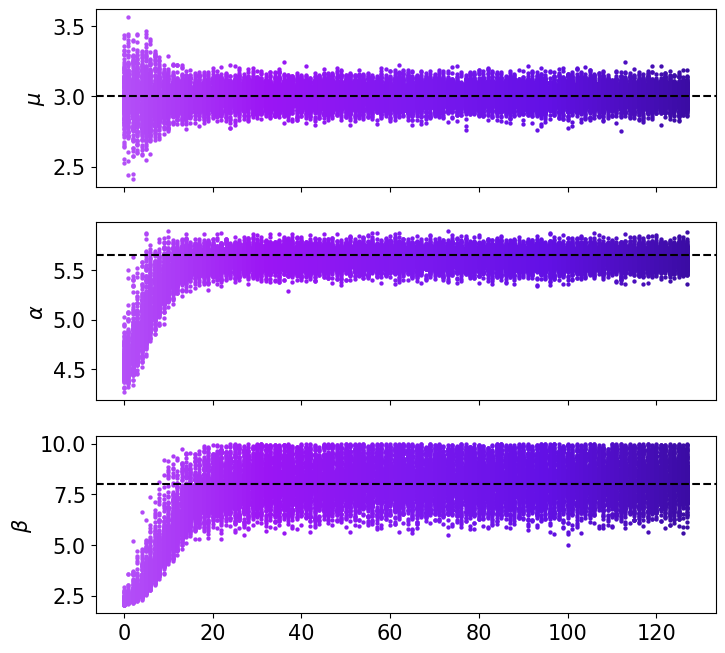

In [66]:
nmax = 128

hybrid_colors = [ "#B450F7", "#9B15F4", "#7D19F0", "#6210E5", "#3a0ca3" ]
hybrid_colors_rgb = [ mpl.colors.to_rgb(c) for c in hybrid_colors ]
cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_purple", hybrid_colors_rgb)

fig, axes = plt.subplots(figsize=(8,8),nrows=3,ncols=1,dpi=100, sharex=True)

for ax, param_idx, latex_label, true_val in zip(axes.flat, [0, 1, 2], [r"$\mu$", r"$\alpha$", r"$\beta$"], [mu_true, alpha_true, beta_true]):    
    for i in np.arange(nmax):
        c = cmap( i/nmax )
        ax.scatter( np.tile(i, (nwalkers,1)), pt_resume["chain_array"][:,i,param_idx].flatten(), s=4.5, color=c)

    ax.set_ylabel(latex_label, fontsize=15)
    ax.axhline(y=true_val, linestyle="--", color="black")
    ax.tick_params(labelsize=15)